# Lyric Analysis

From previous analyses, we have seen that my music is somewhat less popular than the most popular songs on spotify. Additionally, we found hints that suggest my music is more energetic. This could mean a couple different things.  Brand coolness is also partially measured by contrarian themes such as how rebellious a brand is perceived (Warren 2019). On top of this, status matters to how people see a brand. The unfortunate thing is that these two metrics seem to be difficult to be made harmonious. Wikipedia states that rebellions have sprung as a result of ["Political Violence, Class Struggle, State Autonomy, and Societal Values"](https://en.wikipedia.org/wiki/Rebellion). Warren (2019) defined High-Status as something associated with social class prestige, sophistication, and esteem. Almost perfect opposites! But this gives us a great intuition to how brand coolness develops. The coolest brands such as [Nike](https://www.businessinsider.com/nike-has-defined-cool-for-50-years-here-are-the-greatest-hits-2015-12) have been at the forefront of coolness for years partially because they were able to find balance between rebellious, and high status. Any brand (or individual) that can embody this model is without a doubt: cool.

To understand how well I align with these two metrics, I will analyze the sentiment of music, to better understand how positive or negative my music is. Presumably, more positive sentiment could indicate a heavier weight towards high-status, where negative sentiment could indicate more rebellious themes. In order to support those findings, I will follow this with topic analysis using Latent Dirichlet Allocation. Additionally, highly polarized sentiment scores could imply passionate lyrics, which are associated with energetic tracks, and thus coolness.

### Hypotheses
$H_{0}$: My music does not contain rebellious, or high-status themes.

$H_{a}$: My music contains both rebellious and high-status themes.

$H_{b}$: My music contains rebellious, but not high-status themes.

$H_{c}$: My music contains high status, but not rebellious themes.

In [1]:
import pandas as pd
import numpy as np

from string import punctuation
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from langdetect import detect

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from lda import LDA
import pbr

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('my_lyrics.csv')

### Cleaning and Preprocessing
I chose to leave in tracks without lyrics for other analyses, but NaN rows must be dropped for this project. Additionally, all songs should be in English, in order to simplify analysis. To simplify the task, we will only look at songs that have lyrics in English. Sentiment Analysis takes into account the context of the words within the sentence, so the more the sentence makes sense the better. In contrast, TFIDF and LDA need more traditional preprocessing applied. Thus, I will create a seperate column containing the preprocessed lyrics specifically for TFIDF and LDA.

In [3]:
df.shape

(372, 3)

In [4]:
#dropping a song that had nonsense (fan inputted) lyrics
df.drop(12,inplace = True)

In [5]:
#detects songs in foreign languages
def langClean(string):
    if detect(str(string)) != 'en':
        return 'drop'
    else:
        return string

In [6]:
#removing non-english songs
df['lyrics'] = df['lyrics'].apply(langClean)
df = df.loc[df['lyrics'] != 'drop']

#dropping NaN rows, resetting index
df.dropna().reset_index(drop=True,inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
#Shape after dropping Nan rows
df.shape

(281, 3)

In [8]:
df

,track,artist,lyrics
0,DEJA VU - Extended ver.,dave rodgers,See your body into the moonlight Even if I try...
1,Dead Man's Party,Oingo Boingo,I'm all dressed up with nowhere to go Walkin' ...
2,"Bands (feat. Ohgeesy, Fenix Flexin & Master Kato)",Shoreline Mafia,"AceTheFace This ain't a Milly Rock, this a m..."
3,Turn Away the Bad Thing,Ceremony,I'll say It's getting harder for me to be al...
4,No One Lives Forever,Oingo Boingo,You worry too much You make yourself sad You c...
...,...,...,...
276,Cab Deg,Good Morning,My life has aided no-one I've been deceived by...
277,Vibes and Stuff,A Tribe Called Quest,"Let me flaunt the style, I think that the time..."
278,He Sings,Trudy and the Romance,"Baby I need you now I wanna be your guy, I do ..."
279,Lazy Butterfly,Devendra Banhart,"Lazy butterfly, napping on me Dreaming of the ..."


In [9]:
#list of stop words plus a few others I'd like removed
stop = stopwords.words('english') + ['I', 'ill', 'im', 'oh', 'ive', 'like', 'let', 'ha', 'youre', 
                                     'ooh', 'mi', 'que', 'tu', 'te', 'fuck', 'fucking']

In [10]:
def text_clean(txt):
    
    #removes punctuation, strips whitespace, lowers case and turns each input into a list of words
    txt = (txt.translate(str.maketrans('', '', punctuation))
           .strip()
           .lower()
          )
    return txt

In [11]:
#removing stop words, punctuation, and cleaning text
df['lyrics_tok'] = (df['lyrics']
                   .apply(text_clean)
                   .apply(lambda x: ' '.join(word for word in x.split() if word not in (stop)))
                   )

In [12]:
df.head()

,track,artist,lyrics,lyrics_tok
0,DEJA VU - Extended ver.,dave rodgers,See your body into the moonlight Even if I try...,see body moonlight even try cancel pictures mi...
1,Dead Man's Party,Oingo Boingo,I'm all dressed up with nowhere to go Walkin' ...,dressed nowhere go walkin dead man shoulder dr...
2,"Bands (feat. Ohgeesy, Fenix Flexin & Master Kato)",Shoreline Mafia,"AceTheFace This ain't a Milly Rock, this a m...",acetheface aint milly rock money dance dick ai...
3,Turn Away the Bad Thing,Ceremony,I'll say It's getting harder for me to be al...,say getting harder alright eyes adjusting dark...
4,No One Lives Forever,Oingo Boingo,You worry too much You make yourself sad You c...,worry much make sad cant change fate dont feel...


### Sentiment Analysis
Natural Language Processing has brought us a ton of great tools to better understand text data. Methods such as Sentiment Analysis allow us to take look at text data and understand if the document (in this case: lyrics) is mainly positive or negative. 

Using the VADER Sentiment Analysis lexicon, we can better analyze lyrics that contain slang or use complex sentences that are most often used by people. For each input, VADER returns 4 scores that rate a documents negative, neutral, positive, and compound scores. The negative, neutral, and positive scores all rate the prevalence of negative, neutral, and positive words within the document. These scores range from 0-1. The last measure, compound score, is the overall score for the document that takes into account the prevalence of words under each sentiment category and calculates compound sentiment using the context in which these words appear, the ration of positive to negative words. Through this method, neutral words also weigh heavily towards how a documents overall sentiment is calculated. Compound score ranges from -1 (overwhelmingly negative) to 1 (overwhelmingly positive).

The interpretation of Positive or Negative sentiment can depend on the question being asked as well, so its important to look closely at the results. I'll start with a few examples.

In [13]:
#initializing analyzer
SA = SentimentIntensityAnalyzer()

In [14]:
print('Boasty by Wiley')
df.iloc[56,2]

Boasty by Wiley


"Used to stand up on the block, now I'm always on my own Look around, all of us are always on the phone Buy a house cash, I ain't tryna get a loan All the chains and watches I leave them alone Still got the drip though, I be drippin' those All the fresh drips, I be poppin' up in those Bought so many cars, I ain't got enough toes When they saw the black and yellow on my whip, bruddaz froze like   Boasty, boasty Godfather, man are OG Man a half humble, man are boasty Fling a ragga riddim like it's '03 Boasty, house on the coast G My money so long it doesn't know me It's looking at my kids, like I'm boasty I fly around the world 'cause I'm boasty   When I invest it's gotta be a gem If I drop a half then I wanna see a M My brudda drop a three, then he's gotta see a ten Meet buff gyal we're never gonna see again Used to stand up in a dance brudda, 30 man deep In the after party we don't wanna go to sleep Everybody wanna be a don I hear You looking for the top boy, standing right here like  

[Song](https://www.youtube.com/watch?v=JmdkRJi0pZg)
<br>As you can see, this song is pretty positive. The lyrics revolve around the singers being boastful of their success and overall being very confident in themselves, without any doubt in themselves.

In [15]:
print('Sentiment Analysis score for Boasty by Wiley')
SA.polarity_scores(df.iloc[34,2])

Sentiment Analysis score for Boasty by Wiley


{'neg': 0.229, 'neu': 0.502, 'pos': 0.269, 'compound': 0.9719}

The sentiment analyzer is in agreement with our interpretation, as it gives us a compound score of 0.9866, meaning overwhelmingly positive. Though this song isn't talking about sunny days or outright happiness, the analyzer is still able to determine the themes of confidence as positive due to the context in which the words appear in. So we see that this model can detect confidence, but what else?

In [16]:
print('Deja Vu by Dave Rogers')
df.iloc[0,2]

Deja Vu by Dave Rogers


"See your body into the moonlight Even if I try to cancel All the pictures into the mind There's a flashing in my eyes   Don't you see my condition? The fiction - is gonna run it again Can't you see now illusions? Right into your mind   Déjà vu I've just been in this place before Higher on the street And I know it's my time to go Calling you, and the search is a mystery Standing on my feet It's so hard when I try to be me, woah  Déjà vu I've just been in this time before Higher on the beat And I know it's a place to go Calling you and the search is a mystery Standing on my feet It's so hard when I try to be me, yeah   See the future into the present See my past leaves in the distance Try to guess now what's going on And the band begins to play   Don't you see my condition? The fiction - is gonna run it again Can't you see now illusions? Right into your mind   Déjà vu I've just been in this place before Higher on the street And I know it's my time to go Calling you, and the search is a 

[Song](https://www.youtube.com/watch?v=tdeJiw6qMkA)
<br>These lyrics revolve around themes of mystery and an overall difficult situation. Maybe some conflict too? It's not negative in the sense that it's sad or angry, but it does seem a bit negative right?

In [17]:
print('Deja Vu by Dave Rogers')
SA.polarity_scores(df.iloc[0,2])

Deja Vu by Dave Rogers


{'neg': 0.039, 'neu': 0.939, 'pos': 0.022, 'compound': -0.6319}

VADER agrees! The song's mysterious themes have been properly tracked and graded accordingly. This track could be considered "mostly negative" as mystery isn't necessarily a negative theme. But by using context, VADER was able to infer that the singer is experiencing some sort of conflict or struggle.


Sentiment Analysis is a great tool to expand our understanding of my music. As mere audio fatures can be misleading. Plenty of sad songs sound happy, and vice versa. By looking at the lyrics we can get a more complex understanding of just exactly what the music I'm listening to is about.

In [18]:
def sa_scores(string, neg, neu, pos, comp):
    
    '''
    FUNCTION
    -----------
    Analyzes input sentence for sentiment scores. 
    Appends each score to a corresponding list that is created OUTSIDE of the function.
    Returns the original string without modification.
    
    INPUTS
    -----------
    string (string, or iterable array) | Sentence or phrase to be analyzed for sentiment
    neg (list) | An empty list that will hold all NEGATIVE scores for each sentence.
    neu (list) | An empty list that will hold all NEUTRAL scores.
    pos (list) | An empty list that will hold all POSITIVE scores.
    comp (list)| An empty list that will hold all COMPOUND scores. 
    
    
    RETURN
    ------------
    string | The original input string without modification.
    '''
    #assert that the inputs are lists
    assert type(neg) == list
    assert type(neu) == list
    assert type(pos) == list
    assert type(comp) == list
    
    #retrieving sentiment scores
    scores = SA.polarity_scores(string)
    
    #appending scores to the appropriate list
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    comp.append(scores['compound'])
    
    return string

In [19]:
#empty lists to store sentiment score
neg = []
neu = []
pos = []
comp = []

In [20]:
#applying the function
df['lyrics'].apply(sa_scores, args = (neg, neu, pos, comp))

0      See your body into the moonlight Even if I try...
1      I'm all dressed up with nowhere to go Walkin' ...
2      AceTheFace   This ain't a Milly Rock, this a m...
3      I'll say   It's getting harder for me to be al...
4      You worry too much You make yourself sad You c...
                             ...                        
276    My life has aided no-one I've been deceived by...
277    Let me flaunt the style, I think that the time...
278    Baby I need you now I wanna be your guy, I do ...
279    Lazy butterfly, napping on me Dreaming of the ...
280    He had been untrue I had learned of all his li...
Name: lyrics, Length: 281, dtype: object

In [21]:
#assigning lists to df columns
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['comp'] = comp

In [22]:
df['comp'].describe()

count    281.000000
mean       0.145919
std        0.850821
min       -0.999400
25%       -0.872700
50%        0.604800
75%        0.971300
max        0.999400
Name: comp, dtype: float64

(-1, 1)

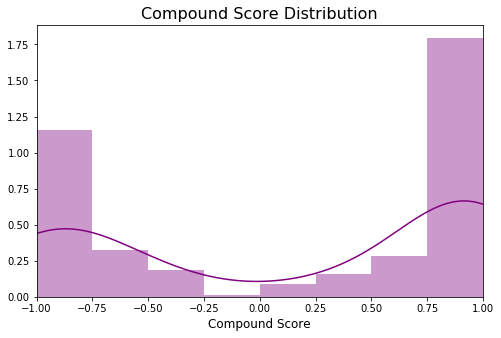

In [23]:
plt.figure(figsize = (8,5))

plt.title('Compound Score Distribution', size = 16)
sns.distplot(df['comp'], bins = 8, color = 'purple')

plt.xlabel('Compound Score', size = 12)
plt.xlim(-1,1)

This is very surprising, as this bimodal distribution is rather pronounced. This could mean good things for when we model topics within the lyrics. This plot alone is indicative of two seperate groups within my music, meaning there could be decent representation for both rebellious and high-status themes.

##### Energy Results
It seems like my songs tend to be either overwhelingly positive or overwhelmingly negative! This finding implies enthusiastic/passionate lyrics are present in my music. These traits are associated with energy and can benefit a brands image. This, coupled with findings highlighted in other notebooks lead me to accept the idea that my music is highly energetic


I'd like to see if any other relationships exist for compound score and other audio features that have been analyzed in previous projects. To do this, I will merge the track info with these scores to see if any correlations exist.

In [24]:
#reading in audio feature data
my_tracks = pd.read_csv('my_tracks.csv')

In [25]:
#merging with sentiment data
my_tracks = my_tracks.merge(df, on = ['track', 'artist'], how = 'right')

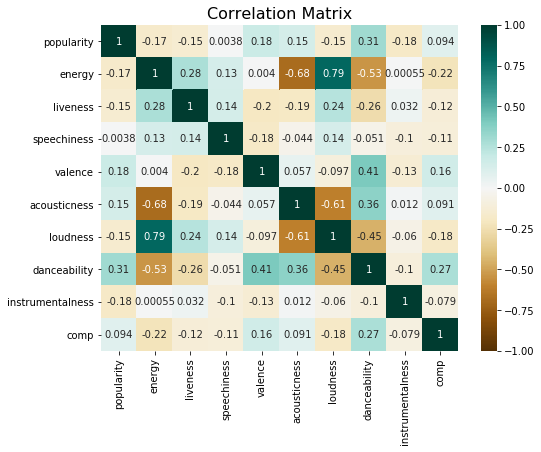

In [26]:
#correlation matrix
c = my_tracks[['popularity', 'energy', 'liveness', 'speechiness', 
           'valence', 'acousticness','loudness', 'danceability',
           'instrumentalness', 'comp']].corr()

plt.figure(figsize = (8,6))
plt.title('Correlation Matrix', size = 16)

#plotting as a heat map
sns.heatmap(c, cmap = 'BrBG', vmin = -1.0, annot = True)

It looks like only weak relationships exist for energy and danceability with compound score. This could be the nature of the relationship, or a product of the fact that my music is only either very positive or very negative. Nonetheless, I will visualize the relationships.

Text(0.5, 0, 'Energy')

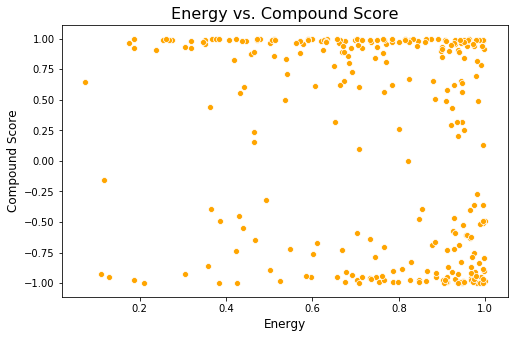

In [27]:
plt.figure(figsize = (8,5))

plt.title('Energy vs. Compound Score', size = 16)

sns.scatterplot(my_tracks['energy'], my_tracks['comp'], color = 'orange')

plt.ylabel('Compound Score', size = 12)
plt.xlabel('Energy', size = 12)

Though weak, there is signs of some sort of relationship. It seems like high energy tracks are more likely to be either very positive or very negative, but more data is required to make more conclusive statements. Since my music is mostly high energy and very negative/very postive, this perceived relationship could just be a product of the data in this unique situation. Still, with the help of clustering tools such as DBSCAN, we can see if these clusters are actually present from a density perspective.

DBSCAN is great for clustering shapes that are unsuitable for K-Means Clustering, as it takes a density-based approach. Additionally, it is very resilient towards outliers and overall noisy points.

In [28]:
#scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(my_tracks[['energy','comp']])

In [29]:
#initializing dbscan model and fitting with data
dbscan = DBSCAN(eps=0.15, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)

Text(0, 0.5, 'Compound Score')

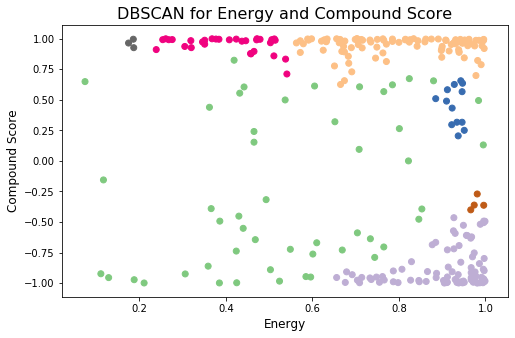

In [30]:
plt.figure(figsize = (8,5))

plt.title('DBSCAN for Energy and Compound Score', size = 16)

plt.scatter(my_tracks['energy'], my_tracks['comp'], c=clusters, cmap = 'Accent')

plt.xlabel('Energy', size = 12)
plt.ylabel('Compound Score', size = 12)

Outliers shown in green. The DBSCAN model has made the clusters within the data very visible. It seems as though different groups do exist within these two features. With this finding, it can be said that a deeper relationship between the two features may exist. Increasing energy could lead to higher likelihood of polarization in sentiment. Which makes intuitive sense, what would an energetic song with neutral sentiment even sound like?

In [31]:
df.loc[df['comp'] == 0]

,track,artist,lyrics,lyrics_tok,neg,neu,pos,comp
140,Entropy: No Meaning Is Also An Answer,Ceremony,Why are we feeding from the guts of reason? Pu...,feeding guts reason pulling universe eyes wont...,0.0,1.0,0.0,0.0


In [32]:
df.iloc[140,2]

"Why are we feeding from the guts of reason? Pulling the universe over our eyes I won't find the answers finding myself Can't find myself when there's nothing to find"

[Song](https://www.youtube.com/watch?v=mow2p7eN2sM)

I love this song, but it's hard to really call it positive or negative without the full context it appears in too. My favorite thing about Ceremony is their interesting (often poetic) lyrics coupled with with the aggressive sound. Really cool band!


Now I'd like to look at the other correlation we identified between danceability and compound score.

Text(0.5, 0, 'Danceability')

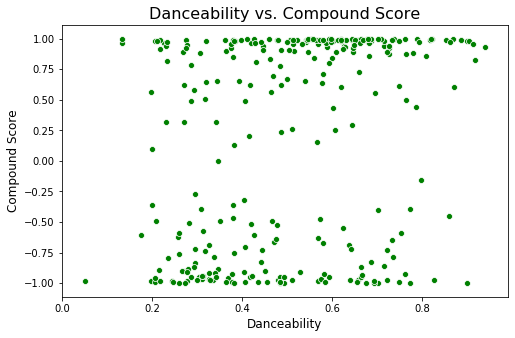

In [33]:
plt.figure(figsize = (8,5))

plt.title('Danceability vs. Compound Score', size = 16)

sns.scatterplot(my_tracks['danceability'], my_tracks['comp'], color = 'green')

plt.ylabel('Compound Score', size = 12)
plt.xlabel('Danceability', size = 12)

I'm noticing another pattern similar to the previous correlation. Here there seems to be hints of clusters that show low danceability being coupled with low compond scores, and high danceability being associated with higher compound scores. I will once again employ DBSCAN to see if these assumptions hold any weight.

In [34]:
#scaling data
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(my_tracks[['danceability','comp']])

In [35]:
#initializing dbscan model
dbscan2 = DBSCAN(eps=0.215, min_samples = 3)
clusters2 = dbscan2.fit_predict(X2_scaled)

Text(0, 0.5, 'Compound Score')

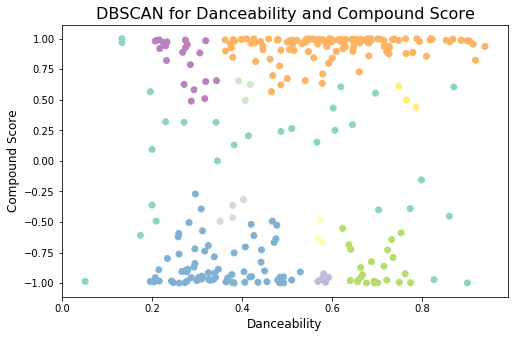

In [36]:
plt.figure(figsize = (8,5))

plt.title('DBSCAN for Danceability and Compound Score', size = 16)

plt.scatter(my_tracks['danceability'], my_tracks['comp'], c=clusters2, cmap = 'Set3')

plt.xlabel('Danceability', size = 12)
plt.ylabel('Compound Score', size = 12)

Although less clean that the relationship with Energy, there does seem to be some underlying clusters within these features as well. The biggest issue with this plot is that there is a lot of noise. What can be said is that  songs with low compound scores tend to be slightly less danceable as well, but there exists a fair amount of exceptions.

Overall, compound score seems to indicative of seem interesting relationships with music. These findings have helped me better understand where I lie on the spectrum of coolness. But in order to come to a decision, we need to better understand just exactly what my music is about using LDA!

### Latent Dirichlet Allocation
When trying to analyze text, it helps a lot to know the topics that are contained within the corpus. This is where Latent Dirichlet Allocation becomes especially useful. In its simplest terms, the model creates topics by sort of working backwards using bayesian probability. First it generates a number of topics (specified by the user), and calculates the probability that each word in the corpus belongs to that topic. This is then multiplied by the probability that the given topic belongs to a given document. This process repeats until the model converges.

In order to operationalize rebellious and high-status lyrics, I will look for topics that would refelect these themes specifically. To do this, I will refer back to the [definition of rebellion](https://www.lexico.com/en/definition/rebellion) and use synonyms such as disobediance and resistance as topics for Guided LDA. Likewise, I will similarly identify words that are associated with high status, such a money, leadership, and esteem.


##### Possible Keywords
Rebellion: 'revolution', 'defy', 'change', 'conflict', 'lead'

Status: 'money', 'respect', 'leader', 'confidence'

In [37]:
#count vector for LDA
ct_vectorizer = CountVectorizer(max_df=0.97, min_df=2, max_features=2000, stop_words = 'english')
ct = ct_vectorizer.fit_transform(df['lyrics_tok'])

In [38]:
#generating word id to word mappings
vocab = ct_vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

In [39]:
#initializing LDA model
model = LDA(n_topics = 10, n_iter = 200, alpha = 0.01, random_state = 1)

#fitting with data
model.fit(ct)

INFO:lda:n_documents: 281
INFO:lda:vocab_size: 1791
INFO:lda:n_words: 20675
INFO:lda:n_topics: 10
INFO:lda:n_iter: 200
C:\Users\BALTHASAR - 02\Anaconda3\lib\site-packages\lda\utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -223445
INFO:lda:<10> log likelihood: -153424
INFO:lda:<20> log likelihood: -149869
INFO:lda:<30> log likelihood: -148470
INFO:lda:<40> log likelihood: -147413
INFO:lda:<50> log likelihood: -146989
INFO:lda:<60> log likelihood: -146451
INFO:lda:<70> log likelihood: -146347
INFO:lda:<80> log likelihood: -145823
INFO:lda:<90> log likelihood: -145638
INFO:lda:<100> log likelihood: -145482
INFO:lda:<110> log likelihood: -145354
INFO:lda:<120> log likelihood: -145162
INFO:lda:<130> log likelihood: -145166
INFO:lda:<140> log likelihood: -144905
INFO

In [40]:
#display top 10 words
n_top_words = 10

#accessing words within each topic
topic_word = model.topic_word_

for topic, topic_dist in enumerate(topic_word):
    
    #grabs top 10 words for each topic from vocab
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]    
    print('Topic {}: {}'.format(topic, ' '.join(topic_words)))

Topic 0: life know got day youll dont young proud try world
Topic 1: dont know night going gonna got cause right freedom good
Topic 2: know tell aint said ride got didnt brothers girl house
Topic 3: line man yeah youve woman body got money boy theres
Topic 4: really got dont love come pieces know whoa want baby
Topic 5: time mind sick feel thing come eyes fall waiting black
Topic 6: yeah rain think fun away way feel far hollywood cause
Topic 7: make time wanna gotta dont want got love cause stop
Topic 8: love dont know baby want heart little need make wanna
Topic 9: way outside away burn gonna stay say got ll change


In [41]:
#topic proportion for each song
doc_topic = model.transform(ct)

#empty dataframe
topic_df = pd.DataFrame()

C:\Users\BALTHASAR - 02\Anaconda3\lib\site-packages\lda\utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


In [42]:
topic_df['track'] = df['track']
topic_df['artist'] = df['artist']

#column containing top (largest proportion) topic for each song
topic_df['topic'] = [doc_topic[i].argmax() for i in range(0,281)]

#dataframe containing normalized proportion of each topics presence in the data
prop_df = topic_df['topic'].value_counts(normalize = True).reset_index()

In [43]:
#normalizing counts
prop_df = topic_df['topic'].value_counts(normalize = True).reset_index()

Text(0, 0.5, 'Proportion of Tracks')

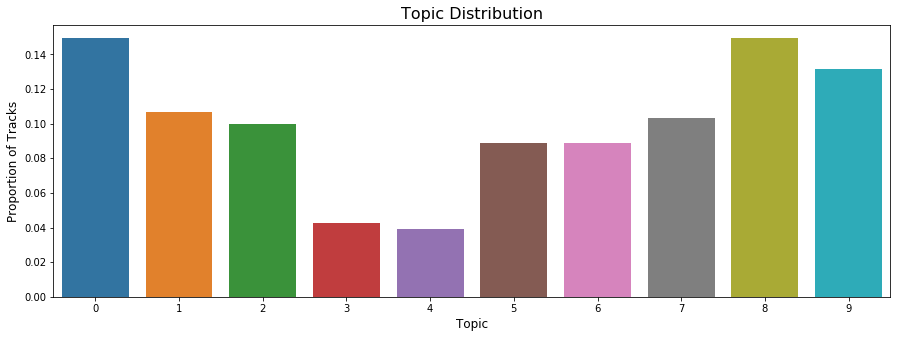

In [44]:
plt.figure(figsize = (15,5))

plt.title('Topic Distribution', size = 16)

sns.barplot(prop_df['index'], prop_df['topic'])

plt.xlabel('Topic', size = 12)
plt.ylabel('Proportion of Tracks', size = 12)

### Key Word Interpretation of Most Prevalent Topics
##### Topic 0: life day dont young try proud world
This topic is pretty abstract but it seems to encompass generally positive themes of pride, youth, and life. Though the presence of "dont" could change the meaning depending on the context it appears in. The focus focus of this topic could potentially be associated with esteem/status, but many other things as well.

##### Topic 1: dont know going gonna cause right freedom good
In this set of words, we find strong themes of both action words, as well as descriptors. Going, gonna, and and cause all imply an imminent action. Right, freedom, and good could refer to many things, but under this context, we can potentially say this topic is about doing the right thing, what is good, or what will bring freedom. However, the presence of "dont" and "know" could mean that there is some sort of conflict in deciding if what is being done is right. This topic could possibly be associated with revolution/conflict.

##### Topic 8: love dont know baby want heart little need make wanna
Topic 8 seems to cover themes surrounding love (love, heart) and desire (want, wanna, need). I believe in this context, baby refers to the use seen in relationships, rather than a literal baby.

##### Topic 9: way outside away burn gonna stay change
Here we see some words that hint towards rebellious themes such as burn and change, but this is still rather vague. More than anything, words such as way, away, outside, and stay indicate some form of changing location. Paired with that, burn, gonna and change could refer to leaving something behind in this context, as they are all actionable words.


### Overall Topic Interpretation
Topic 1 and Topic 9 both seem to share themes surrounding change, the right cause, and leaving things behind. Combined, these topics make up about 23% of my tracks. The themes present in these topics are suggestive of rebellion and fighting for what is right. Topic 0 and Topic 8 seemed to be more general positive themes that aren't necessarily related to rebellion or status.

# Conclusion

In this analysis, we found that my music is confirmed to be highly energetic. Our other goal was to identify rebellious or high-status themes. We have operationalized keywords for these themes as follows:<br>
<br>Rebellion: 'revolution', 'defy', 'change', 'conflict', 'leader'

Status: 'money', 'respect', 'leader', 'confidence'
<br>
<br>(Note: Lead appears in both groups as leadership can be associated with a rebellious movement as well as a person in power and thus high-status)

The findings from sentiment analysis showed that the majority of my music was of either overwhelmingly positive, or overwhelmingly negative sentiment. Positive themes could imply confidence, happiness, love, and agreement. Negative sentiment could imply anger, mystery, conflict, and disagreement. Using LDA, we were able to identify my music as having a notable proportion of tracks that followed rebellious themes surrounding change, and fighting for the right cause. 

With these findings, I am comfortable rejecting the null hypothesis that states neither rebellious nor high-status themes are present within my music. That being said, there is not enough conclusive evidence to suggest that high-status themes are well-represented within the data and thus we cannot say with confidence that themes are present for a notable proportion of songs. Through this analysis, Topic 1 and Topic 9 have been identified as rebellious themes and are found in 23.8% of my tracks. These topics thus make up a small majority and provide good evidence for a rebellious trend. To supplement this, the strong presence of highly polarized sentiment and high energy tracks is indicative of lyrics with a strong message. Rebellious music can vary in subject but common themes revolve around a passionate and loud message.

Thus, I accept the alternative hypothesis $H_{b}$: My music contains rebellious, but not high-status themes.

### Discussion
In order to improve my coolness, I should seek to listen to more music that is associated with high status themes. Spotify offers several playlists that encompass [high-society](https://open.spotify.com/playlist/2hjPA4vpHPa1UFphKhi16N?si=hlgvjBwERDmye4ZOStqRzQ), [confidence](https://open.spotify.com/playlist/37i9dQZF1DX4fpCWaHOned?si=gLccAw2JRreOu62OqyuBFg), and even [space-themed classical music](https://open.spotify.com/playlist/37i9dQZF1DX0i61tT0OnnK?si=ezjQQCOhTrS2QPtgi324Ww). These three playlists will help fill the gaps within my music library and hopefull at the end of it all I will come out as a high-status individual, and thus: cooler.

On the subject of compound score and energy/danceability: though the findings are fascinating, we must be careful on extrapolating to the larger population. Previous analyses have identified my library as somewhat anomalous. Thus, it is difficult to say that such a theme exists for general music. After all, this could simply just be because of my particular taste in music.

Though LDA has its drawbacks, it is very sensitive to tuning and the size of the corpus. Future improvements to this approach would require more data. Additionally, my music varies greatly in genres. Different genres are known to have different lyrical themes, and I tend to listen to a lot of punk music, which is notorious for its rebellious themes. This fact can lead to difficulties with LDA, as the genre's topics don't overlap perfectly. Thus the model struggles to formulate topics that properly represent the data. In the future, this model may be better applied on a more specific subset of data, such as a playlist containing a specific genre of music.

#### References
Warren, C., Batra, R., Loureiro, S. M., &amp; Bagozzi, R. P. (2019). Brand Coolness. Journal of Marketing, 83(5), 36-56. doi:10.1177/0022242919857698